# Script for generating graphs for KAE EnKF Paper section 4.3.1: KAE EnKF vs other DMD variants - single frequency

In [7]:
#Copy this script and then edit to make specific to your dataset for parameter tweaking
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import gaussian_kde

#Set matplotlib settings as required
%matplotlib inline
scaling = 1.6
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rcParams["figure.figsize"] = (16,8) # (w, h)
plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import numpy as np
from scipy.sparse.linalg import svds

from libraries.KAE import KoopmanAE, LuschLoss
from libraries.DMDEnKF import EnKF
import simple_sin_helpers as ssf

### Generate example synthetic data trajectory and plot

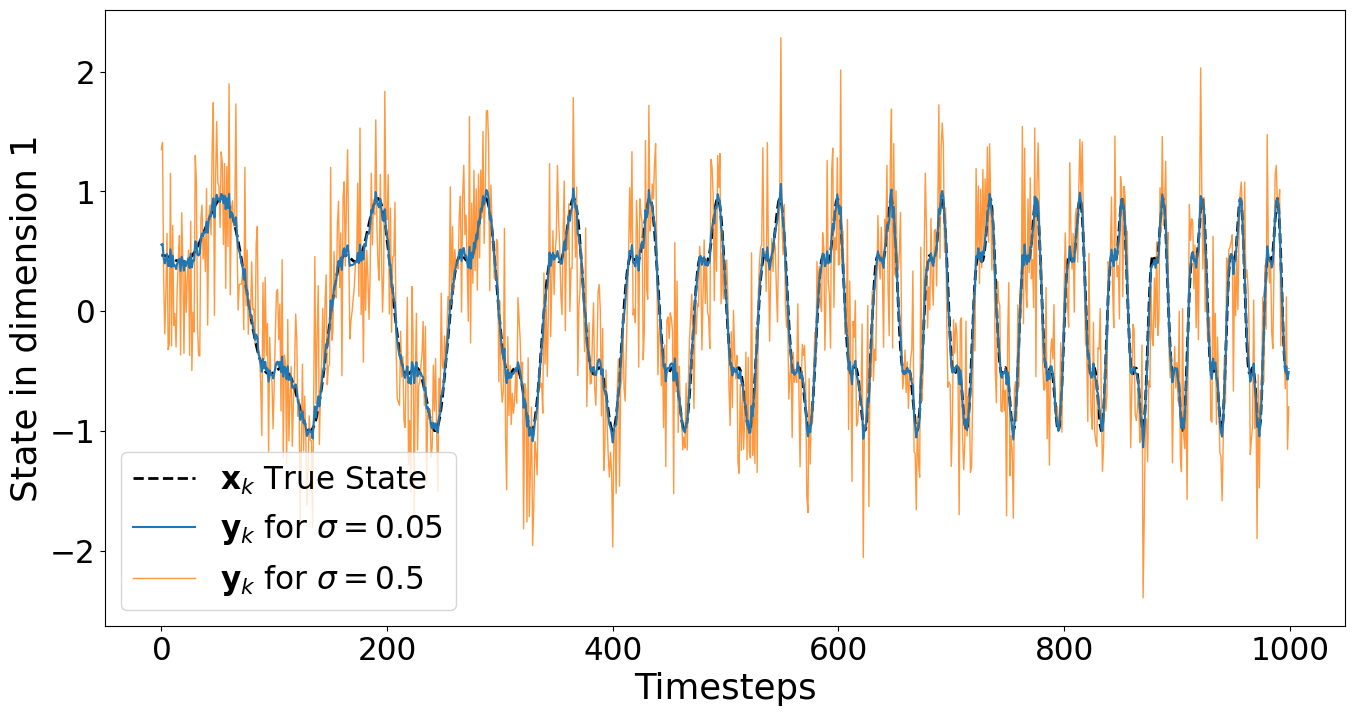

In [3]:
#example noise data plot

#data generation parameters
num_data = 1000
num_spinup = 200
theta_start = np.pi/128
theta_end = np.pi/16
r_start = 1
r_end = 1
obs_cov = 0.05**2    #NOTE: Set to 0.5**2 for high levels of noise
data_dim = 100
power = 3    #Governs the degree of nonlinearity in the system

#Random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
#dataset and dataloaders
dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)

#do this again to ensure randomly generated measurment operator is the same for both (for graph purposes)
torch.manual_seed(0)
np.random.seed(0)
#dataset and dataloaders for high noise to show example data
highnoise_dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,0.5**2,data_dim,power)

#Plot the true state, alongside the low/high noise generated measurements
plt.plot(dataset.true_highdim_data.T[0], label =r'$\mathbf{x}_k$ True State',alpha = 1, linewidth='2', ls='--',color='black')
plt.plot(dataset.data.T[0],alpha=1, color='tab:blue',zorder=10,label=r'$\mathbf{y}_k$ for $\sigma = 0.05$')
plt.plot(highnoise_dataset.data.T[0],alpha=0.8,color='tab:orange', label=r'$\mathbf{y}_k$ for $\sigma = 0.5$',linewidth='1')
plt.xlabel('Timesteps')
plt.ylabel('State in dimension 1')
plt.legend()
#plt.savefig('graphs/sin5_bothnoise_data_time_series.png',bbox_inches='tight')

### Setup other iterative DMD variants, then train on the relevant data

In [6]:
#Parameters and set up for EDMD variants

#Convert the data into a numpy array ready for time-delay stacking
np_data = np.array(dataset.data)

'''Time-delay Embedding'''
#set number of time delays to use and create data
hankel_dim = 5
np_data = ssf.hankelify(np_data.T,hankel_dim).T
hankel_dmdenkf_num_spinup = num_spinup + 1 - hankel_dim

#set other DMD variants parameters like rank, window size for WEDMD
rank = 2
window_size = 10

#Set DMD EnKF filter uncertainties
system_cov_const = 0.05**2
obs_cov_const = obs_cov
eig_cov_const = 0.005**2

In [ ]:
#train EDMD models - Note this step can take some time
stdmds = ssf.iterate_streaming_tdmd(np_data,rank)
wtdmds = ssf.windowed_tdmd(np_data,rank,window_size)
dmdenkf = ssf.apply_dmdenkf(np_data.T,hankel_dmdenkf_num_spinup,rank,system_cov_const,obs_cov_const,eig_cov_const,ensemble_size=500)

### Setup KAE EnKF and train on relevant data

In [ ]:
#standard setup, needed to be done before parameter tweaking to ensure all vars set correctly

#ALL KAE EnKF PARAMETERS

#KAE variables
input_size = data_dim    #measurement dimension
num_frequencies = 1
intermid_size = 10    #encoder/decoder hidden layer dimensions

#Create KAE encoder/decoder networks
encoder_module_list = nn.ModuleList([nn.Linear(input_size,intermid_size),nn.ReLU(),
                                     nn.Linear(intermid_size,intermid_size),nn.ReLU(),
                                     nn.Linear(intermid_size,num_frequencies*2)])
decoder_module_list = nn.ModuleList([nn.Linear(num_frequencies*2,intermid_size),nn.ReLU(),
                                     nn.Linear(intermid_size,intermid_size),nn.ReLU(),
                                     nn.Linear(intermid_size,input_size)])

#training parameters
batch_size = 64
epochs = 100
global_fourier_interval = 10
print_interval = 10


#dataset and dataloaders
#Note dataloader only draws data from inside the spin-up indices
train_dataloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)

#No validation set for this example
#val_dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)
#val_dataloader = DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_dataloader = None

#initialise Koopman AE, loss function and optimiser and attatch them to the KAE class
kae = KoopmanAE(input_size,num_frequencies,encoder_module_list,decoder_module_list)
lossfunc = LuschLoss
#this is a variable used for setting weightings of loss function components (a1,a2,a3,a4,a5)
#standard, linear, reconstruction, amplitude stability, regularisation
loss_hyperparameters = [1,1,1,1,0.01]
opt = optim.AdamW(kae.parameters(),lr=0.01)
'''No svd init used in this example'''
#U, _, _ = svds(np.array(dataset.spinup_data).T,k=intermid_size)
#U = torch.from_numpy(U.astype(np.float32).copy())
kae.set_training_attributes(opt,lossfunc,loss_hyperparameters,train_dataloader,val_dataloader=val_dataloader,svd_init=None)

#Move to GPU (sadly needed to be done this way for JIT compiler compatibility)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
kae = kae.to(dev)
kae.device = dev
kae.linear_koopman_layer.device = dev

#TRAINING LOOP
kae.run_training_loop(epochs,global_fourier_interval=global_fourier_interval,print_interval=print_interval)

In [7]:
#KAE EnKF Filter section run - hence run over all subsequent data after the spin-up phase
sys_cov_const = 0.05**2
param_cov_consts = np.array([0.0005**2,0.005**2])
obs_cov_const = obs_cov
init_cov_const = obs_cov_const

kaeenkf = ssf.apply_kae_enkf_filter(kae,dataset.filter_data,sys_cov_const,param_cov_consts,obs_cov_const,init_cov_const,ensemble_size = 100)

### Plot eigenvalue modulus and argument estimates from each modelling method

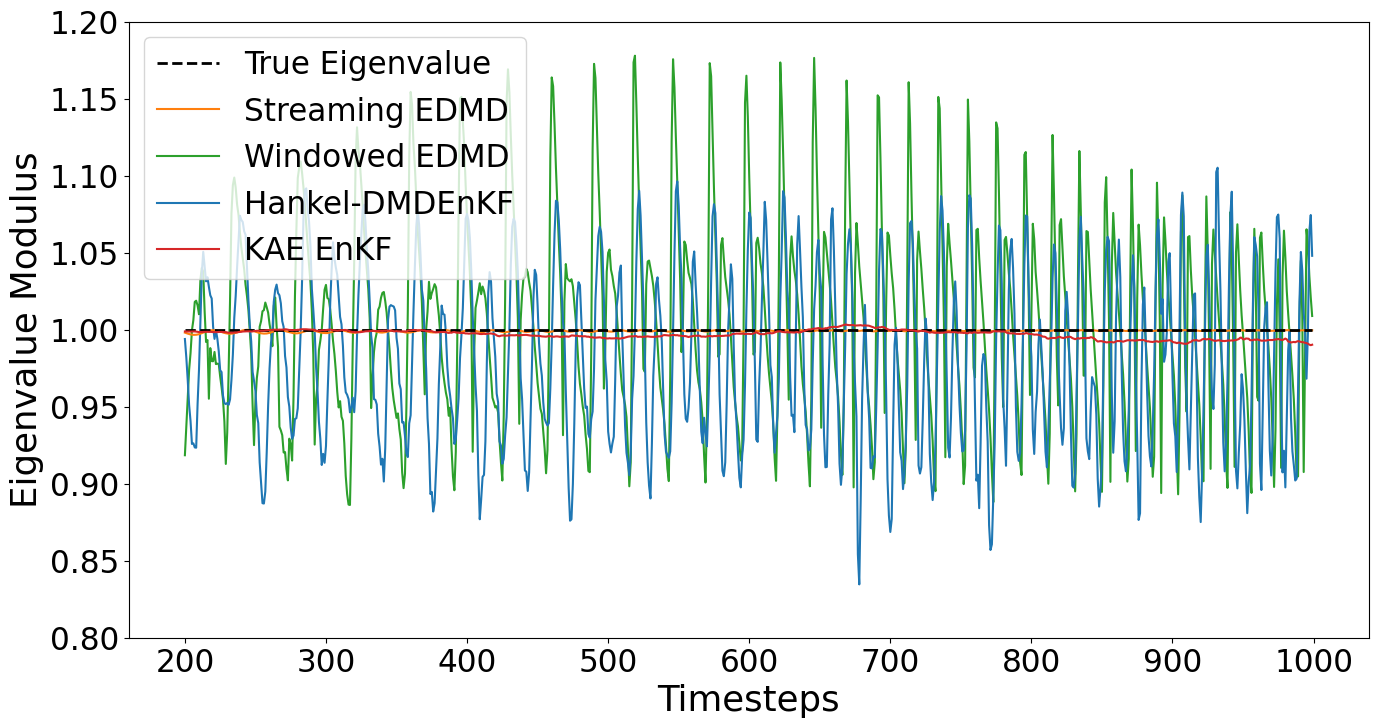

In [8]:
#View the eignevalue modulus predictions for each method

num_to_keep = num_data-num_spinup
x = range(200,1000)
plt.plot(x,np.ones(num_to_keep),label='True Eigenvalue',c='black',linewidth='2', ls='--',zorder=3)
plt.plot(x,[ssf.get_dom_eigs_mod(d.eigs) for d in stdmds][-num_to_keep:],label='Streaming EDMD',c='tab:orange',zorder=2)
plt.plot(x,[ssf.get_dom_eigs_mod(d.eigs) for d in wtdmds][-num_to_keep:],label='Windowed EDMD',c='tab:green',zorder=0)
plt.plot(x,[abs(x[-2]) if dmdenkf.conj_pair_list else get_dom_eigs_mod(x[-2:]) for x in dmdenkf.X][-num_to_keep:],
        label='Hankel-DMDEnKF',c='tab:blue',zorder=0)
plt.plot(x,[x[-2] for x in kaeenkf.X][-num_to_keep:],label='KAE EnKF',c='tab:red',zorder=3)
plt.legend()
plt.ylim(0.8, 1.2)
plt.xlabel('Timesteps')
plt.ylabel('Eigenvalue Modulus')
#plt.savefig('graphs/0.05_edmd_eigmod_trajectory.png',bbox_inches='tight')

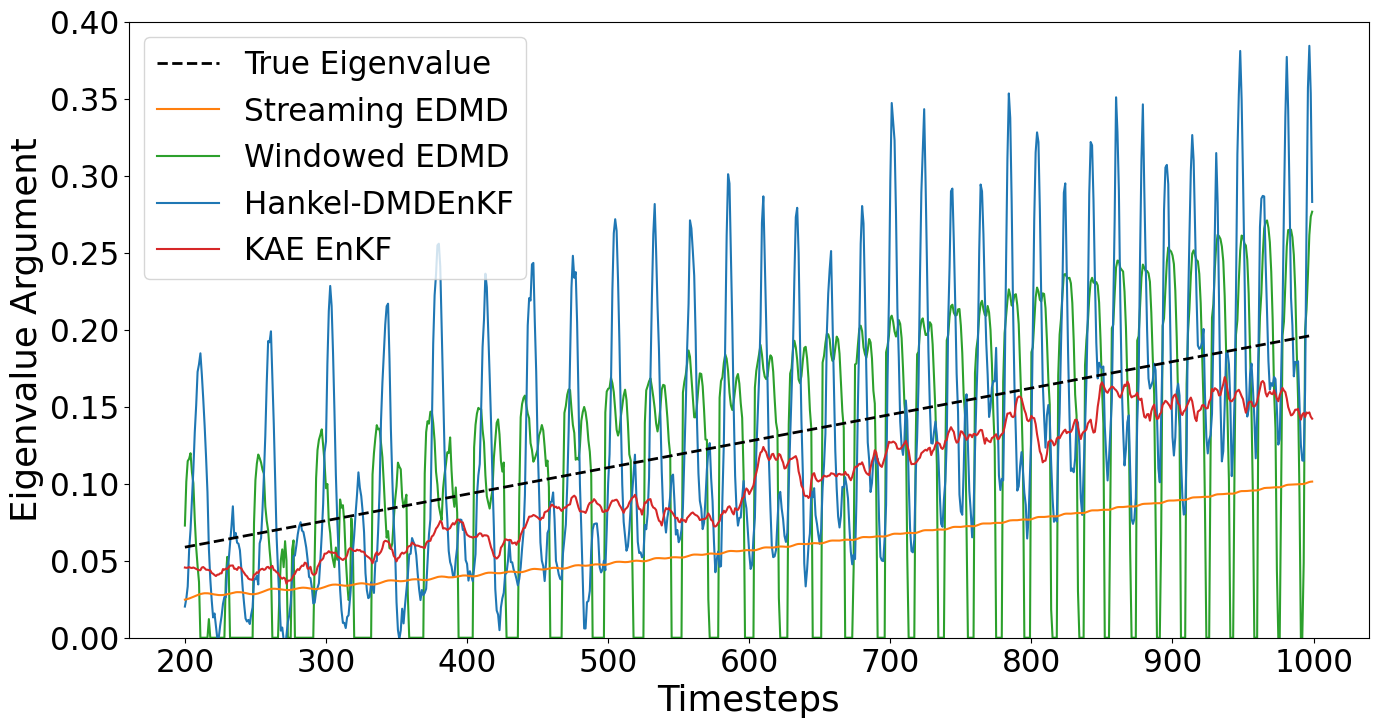

In [9]:
#View the eignevalue argument predictions for each method
num_to_keep = num_data-num_spinup
plt.plot(x,dataset.thetas[-num_to_keep:],c='black',linewidth='2', ls='--',zorder=1,label='True Eigenvalue')
plt.plot(x,[ssf.get_dom_eigs_arg(d.eigs) for d in stdmds][-num_to_keep:],label='Streaming EDMD',c='tab:orange',
        zorder=2)
plt.plot(x,[ssf.get_dom_eigs_arg(d.eigs) for d in wtdmds][-num_to_keep:],label='Windowed EDMD',c='tab:green',zorder=0)
plt.plot(x,[np.real(x[-1]) if dmdenkf.conj_pair_list else 0 for x in dmdenkf.X][-num_to_keep:],
         label='Hankel-DMDEnKF',c='tab:blue',zorder=0)
plt.plot(x,[abs(2*np.pi - x[-1]) if x[-1]>np.pi else x[-1] for x in kaeenkf.X][-num_to_keep:],
         label='KAE EnKF', c='tab:red',zorder=3)
plt.legend()
plt.ylim(0, 0.4)
plt.xlabel('Timesteps')
plt.ylabel('Eigenvalue Argument')
#plt.savefig('graphs/0.05_edmd_eigarg_trajectory.png',bbox_inches='tight')

### Generate forecasts for each method over multiple runs, and examine forecasts error distribution

In [3]:
#forecast with each method p-steps ahead, and save the forecast's error distributions for easier future analysis

#Random seeds for reproducibility
torch.manual_seed(1)
np.random.seed(1)

#pickle_dic = []
with open(f'pickles/edmd_preds_nonlinear_sin.pkl', 'rb') as f:
    pickle_dic = pickle.load(f)
for i in range(5):
    print(i)
    #dataset and dataloaders
    dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)

    #Parameters and set up for EDMD variants
    np_data = np.array(dataset.data)

    '''Time-delay Embedding'''
    hankel_dim = 5
    np_data = ssf.hankelify(np_data.T,hankel_dim).T
    hankel_dmdenkf_num_spinup = num_spinup + 1 - hankel_dim

    rank = 2
    window_size = 10
    system_cov_const = 0.05**2
    obs_cov_const = obs_cov

    eig_cov_const = 0.005**2

    #train EDMD models
    stdmds = ssf.iterate_streaming_tdmd(np_data,rank)
    wtdmds = ssf.windowed_tdmd(np_data,rank,window_size)
    dmdenkf = ssf.apply_dmdenkf(np_data.T,hankel_dmdenkf_num_spinup,rank,system_cov_const,obs_cov_const,eig_cov_const,ensemble_size=500)

    #standard setup, needed to be done before parameter tweaking to ensure all vars set correctly

    #ALL PARAMETERS

    #KAE variables
    input_size = data_dim    #hardsin uses 100
    num_frequencies = 1    #hard2sin uses 2
    intermid_size = 10
    encoder_module_list = nn.ModuleList([nn.Linear(input_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,num_frequencies*2)])
    decoder_module_list = nn.ModuleList([nn.Linear(num_frequencies*2,intermid_size),nn.ReLU(),nn.Linear(intermid_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,input_size)])

    #training
    batch_size = 64
    epochs = 100
    global_fourier_interval = 10
    print_interval = 10


    #dataset and dataloaders
    train_dataloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)

    #No validation set for this example
    #val_dataset = ssf.HighDimSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)
    #val_dataloader = DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)
    val_dataloader = None

    #initialise Koopman AE, loss function and optimiser and attatch them to the KAE class
    kae = KoopmanAE(input_size,num_frequencies,encoder_module_list,decoder_module_list)
    lossfunc = LuschLoss
    #this is a variable used for setting weightings of loss function components (a1,a2,a3,a4,a5)
    #standard, linear, reconstruction, amplitude stability, regularisation
    loss_hyperparameters = [1,1,1,1,0.01]
    opt = optim.AdamW(kae.parameters(),lr=0.01)
    '''No svd init used in this example due to lower dimension of input data than layer size'''
    U, _, _ = svds(np.array(dataset.spinup_data).T,k=intermid_size)
    U = torch.from_numpy(U.astype(np.float32).copy())
    kae.set_training_attributes(opt,lossfunc,loss_hyperparameters,train_dataloader,val_dataloader=val_dataloader,svd_init=None)

    #Move to GPU (sadly needed to be done this way for JIT compiler compatibility)
    dev = 'cuda' if torch.cuda.is_available() else 'cpu'
    kae = kae.to(dev)
    kae.device = dev
    kae.linear_koopman_layer.device = dev

    #TRAINING LOOP
    kae.run_training_loop(epochs,global_fourier_interval=global_fourier_interval,print_interval=print_interval)

    sys_cov_const = 0.05**2
    param_cov_consts = np.array([0.0005**2,0.005**2])
    obs_cov_const = obs_cov
    init_cov_const = obs_cov_const

    kaeenkf = ssf.apply_kae_enkf_filter(kae,dataset.filter_data,sys_cov_const,param_cov_consts,obs_cov_const,init_cov_const,ensemble_size = 100)


    p_step = 10
    num_to_keep = num_data-num_spinup
    #store predictions adjusted to same length, and aligned with data
    stdmds_preds = ssf.edmd_list_pred(np_data,stdmds,p_step)[-num_to_keep:-p_step,:data_dim]
    wtdmds_preds = ssf.edmd_list_pred(np_data,wtdmds,p_step)[-num_to_keep:-p_step,:data_dim]
    dmdenkf_preds = np.vstack([ssf.dmdenkf_ensembles_p_step_pred(dmdenkf,ensemble,p_step)
                               for ensemble in dmdenkf.ensembles])[-num_to_keep:-p_step,:data_dim]
    kaeenkf_preds = np.vstack([ssf.kaeenkf_ensembles_p_step_pred(kae,ensemble,p_step)
                               for ensemble in kaeenkf.ensembles])[-num_to_keep:-p_step]

    true_values = np.array(dataset.true_highdim_data[-(num_to_keep-p_step):])

    pickles = [true_values, stdmds_preds, wtdmds_preds, dmdenkf_preds, kaeenkf_preds]
    pickle_dic.append(pickles)
    #with open(f'pickles/edmd_preds_nonlinear_sin.pkl', 'wb') as f:
    #    pickle.dump(pickle_dic, f)

0


/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number 167115.203125. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number 233412.34375. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number 208552.75. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


0
tensor([1.])
tensor([1.4454])
Train Loss: 2.398497998714447
10
tensor([0.9991])
tensor([1.4916])
New Frequency: 6.024589248930815
Train Loss: 1.6544317603111267
20
tensor([0.9999])
tensor([6.0590])
Train Loss: 1.5782217681407928
New Frequency: 6.21678902195355
30
tensor([0.9975])
tensor([6.2631])
Train Loss: 0.32703834027051926
New Frequency: 0.04193449593223306
40
tensor([0.9974])
tensor([0.0313])
Train Loss: 0.29162491858005524
New Frequency: 0.05241811991529132
50
tensor([0.9997])
tensor([0.0476])
Train Loss: 0.25611135363578796
60
tensor([0.9993])
tensor([0.0415])
Train Loss: 0.26526373252272606
New Frequency: 0.06989082655372177
70
tensor([0.9990])
tensor([0.0618])
Train Loss: 0.2417212650179863
80
tensor([0.9991])
tensor([0.0531])
Train Loss: 0.22780486568808556
New Frequency: 0.02096724796611653
90
tensor([0.9938])
tensor([0.0164])
Train Loss: 0.22811808809638023
1


/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number 125382.046875. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number 127530.21875. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number 137806.34375. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number 199103.9375. Consider preprocessing data, passing in augmented data
matrix, 

0
tensor([1.])
tensor([1.3763])
Train Loss: 2.347287952899933
10
tensor([0.9999])
tensor([1.4892])
New Frequency: 0.27606876488720095
Train Loss: 1.7143701612949371
20
tensor([0.9988])
tensor([0.0787])
Train Loss: 1.2602969706058502
New Frequency: 0.09784715717521046
30
tensor([0.9984])
tensor([0.0254])
Train Loss: 0.46108241379261017
New Frequency: 0.027956330621488702
40
tensor([0.9983])
tensor([0.0147])
Train Loss: 0.3173593133687973
New Frequency: 0.06290174389834959
50
tensor([1.0017])
tensor([0.0622])
Train Loss: 0.2918613702058792
60
tensor([0.9976])
tensor([0.0454])
Train Loss: 0.27883367240428925
New Frequency: 0.02096724796611653
70
tensor([0.9997])
tensor([0.0306])
Train Loss: 0.10621335357427597
80
tensor([1.0017])
tensor([0.0402])
Train Loss: 0.09538293443620205
New Frequency: 0.05241811991529132
90
tensor([1.0004])
tensor([0.0407])
Train Loss: 0.07654581032693386
2


/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number 13535080.0. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


0
tensor([1.])
tensor([0.7799])
Train Loss: 2.1211602687835693
10
tensor([1.0017])
tensor([0.8508])
New Frequency: 0.02096724796611653
Train Loss: 1.653778314590454
20
tensor([1.0006])
tensor([-0.0051])
Train Loss: 0.4983299821615219
New Frequency: 6.255228976558097
30
tensor([1.0015])
tensor([6.2822])
Train Loss: 0.30190396308898926
New Frequency: 6.283185307179586
40
tensor([0.9956])
tensor([6.2778])
Train Loss: 0.29122229292988777
New Frequency: 6.220283563281237
50
tensor([0.9992])
tensor([6.2610])
Train Loss: 0.27015966922044754
60
tensor([1.0008])
tensor([6.2877])
Train Loss: 0.2789769023656845
New Frequency: 0.038439954604546966
70
tensor([1.0004])
tensor([-0.0224])
Train Loss: 0.278937429189682
80
tensor([0.9975])
tensor([-0.0078])
Train Loss: 0.29663216322660446
New Frequency: 6.244745352575039
90
tensor([1.0008])
tensor([6.2732])
Train Loss: 0.3037307932972908
3


/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number 106453.6953125. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number 151232.53125. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


0
tensor([1.])
tensor([3.1711])
Train Loss: 2.666773557662964
10
tensor([1.0008])
tensor([3.2598])
New Frequency: 0.19569431435042092
Train Loss: 1.5391748696565628
20
tensor([1.0000])
tensor([0.1209])
Train Loss: 1.8612942695617676
New Frequency: 0.03494541327686088
30
tensor([0.9990])
tensor([-0.0034])
Train Loss: 0.31932487338781357
New Frequency: 0.0034945413276860878
40
tensor([0.9994])
tensor([-0.0053])
Train Loss: 0.2728453204035759
New Frequency: 6.213294480625864
50
tensor([0.9989])
tensor([6.2354])
Train Loss: 0.24524183943867683
60
tensor([0.9981])
tensor([6.2825])
Train Loss: 0.3298811987042427
New Frequency: 0.03494541327686088
70
tensor([0.9989])
tensor([0.0025])
Train Loss: 0.26666639000177383
80
tensor([1.0000])
tensor([0.0033])
Train Loss: 0.25640688836574554
New Frequency: 6.269207141868842
90
tensor([1.0010])
tensor([6.2906])
Train Loss: 0.26502562686800957
4


/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number 693565.3125. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number 112346.8515625. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


0
tensor([1.])
tensor([3.7863])
Train Loss: 2.2417051792144775
10
tensor([1.0027])
tensor([3.8758])
New Frequency: 0.10833078115826873
Train Loss: 1.5378915071487427
20
tensor([1.0005])
tensor([-0.0112])
Train Loss: 0.3736964836716652
New Frequency: 0.04542903725991914
30
tensor([0.9994])
tensor([0.0151])
Train Loss: 0.28208207339048386
New Frequency: 6.213294480625864
40
tensor([1.0009])
tensor([6.3038])
Train Loss: 0.27555014193058014
New Frequency: 0.013978165310744351
50
tensor([1.0003])
tensor([0.0120])
Train Loss: 0.28461918234825134
60
tensor([0.9964])
tensor([0.0084])
Train Loss: 0.3103916570544243
New Frequency: 6.255228976558097
70
tensor([1.0016])
tensor([6.2918])
Train Loss: 0.289262518286705
80
tensor([0.9963])
tensor([6.2949])
Train Loss: 0.2830009311437607
New Frequency: 0.03145087194917479
90
tensor([1.0009])
tensor([0.0340])
Train Loss: 0.2756142169237137


In [8]:
with open(f'pickles/edmd_preds_nonlinear_sin.pkl', 'rb') as f:
    pickle_dic = pickle.load(f)
    
pickle_dic = np.hstack(pickle_dic)

true_values = pickle_dic[0]
dists = []
for preds in pickle_dic[1:]:
    dist = [(np.linalg.norm(pred-truth)**2)/len(truth) for pred,truth in zip(preds,true_values)]
    dists.append(dist)

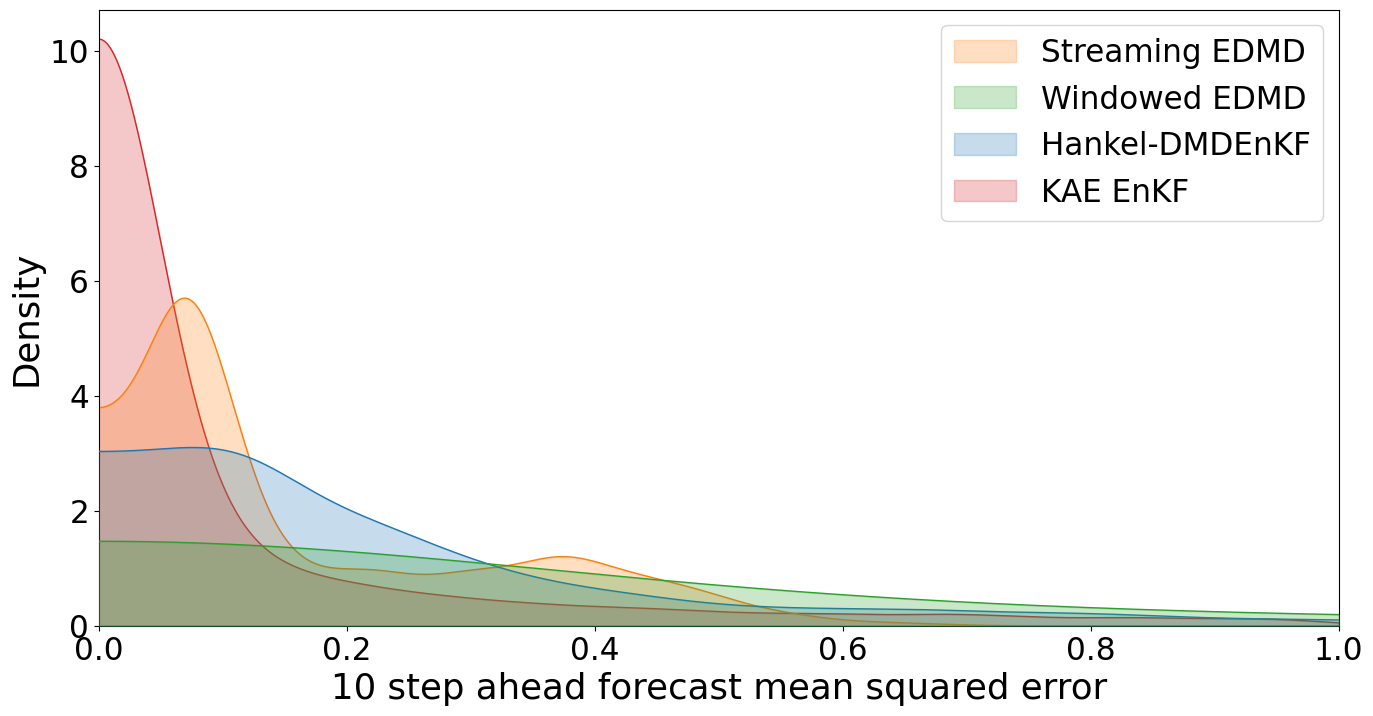

In [10]:
x_lim = 1
num_points = 10000
cols = ['tab:orange','tab:green','tab:blue','tab:red']
labs = ['Streaming EDMD', 'Windowed EDMD', 'Hankel-DMDEnKF', 'KAE EnKF']
zorders = [2,4,3,1]
#dist_max = max([i for j in dists for i in j])
x = np.linspace(0,x_lim,num_points)
for i,dist in enumerate(dists):
    kde = gaussian_kde(dist)
    boundary_reflect_kde = (kde(x)+kde(-x))
    plt.plot(x,boundary_reflect_kde,c=cols[i],linewidth=1,zorder=zorders[i])
    plt.fill_between(x,boundary_reflect_kde,0,alpha=0.25,color=cols[i],
                     label=labs[i],zorder=zorders[i])
plt.xlabel('10 step ahead forecast mean squared error')
plt.ylabel('Density')
plt.ylim(0)
plt.xlim(0,x_lim)
plt.legend()
#plt.savefig('graphs/edmd_forecast_mse_dist.png',bbox_inches='tight')